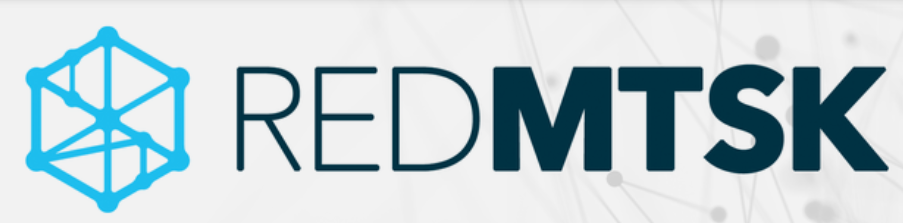

#**PROYECTO DE CLASIFICACIÓN DE TEMÁTICAS EN LA LITERATURA SOBRE LA TEORIA MTSK MEDIANTE TÉCNICAS DE APRENDIZAJE NO SUPERVISADO.**

**AUTORES:**
- CAROLINA ROJAS
- JHEREMY REYES

**INTRODUCCIÓN**

El presente proyecto se desarrolla a partir de un conjunto de datos construido por Luz Maricel Elorreaga y Carolina Rojas, quienes han facilitado el material con fines académicos, en el marco de un proyecto interno en el curso de Machine learning II, cuyo propósito es generar un clasificador automático de temáticas relacionadas con la teoría del MTSK (_Mathematics Teaching Specialized Knowledge_). Esta teoría forma parte de la línea de investigación centrada en el conocimiento del profesor de matemáticas, y busca describir, analizar y comprender la naturaleza del conocimiento profesional docente en la enseñanza de las matemáticas.

El dataset utilizado está conformado por 188 documentos, entre artículos publicados en revistas científicas de educación matemática y ponencias presentadas en congresos o eventos académicos. De cada documento se ha recopilado información textual relevante —título, resumen y palabras clave— con el fin de explorar patrones semánticos y temáticos mediante técnicas de aprendizaje no supervisado.

Actualmente, la teoría MTSK organiza su producción académica en cinco grandes temáticas, en las cuales deben clasificarse todos los trabajos relacionados con este marco teórico. Sin embargo, no existe hasta el momento una herramienta automatizada que permita identificar de manera eficiente la temática a la que pertenece un documento nuevo o desconocido. Este vacío motiva el desarrollo del presente proyecto, que busca aplicar modelos de clustering y reducción de dimensionalidad para identificar agrupamientos naturales en los textos y analizar su correspondencia con las categorías temáticas establecidas.

De manera complementaria, la clasificación automática de documentos permitirá a los investigadores detectar tendencias y áreas de especialización dentro de la teoría MTSK, así como reconocer los tópicos matemáticos que se abordan con mayor frecuencia (por ejemplo: funciones, derivadas, geometría, vectores, entre otros).

_Las cinco temáticas definidas por la Red MTSK son las siguientes:_

- T1. Aplicaciones de MTSK en la formación de profesores. Centrada en los usos del modelo MTSK en procesos de formación inicial y continua del profesorado, el análisis de planes de estudio y materiales educativos, y la reflexión sobre el conocimiento especializado que estos implican.

- T2. Investigaciones sobre el formador de profesores de matemáticas. Analiza el conocimiento, la identidad profesional y las prácticas del formador, así como la relación entre el conocimiento didáctico del contenido y el conocimiento matemático especializado.

- T3. MTSK en relación con distintos tópicos y etapas. Examina investigaciones sobre el desarrollo del MTSK en torno a temas específicos (funciones, fracciones, geometría, etc.) y en diferentes niveles educativos.

- T4. Desarrollo del MTSK. Busca profundizar en los subdominios del modelo (como el KPM) y en su relación con dimensiones afectivas, creencias y estructuras del conocimiento especializado.

- T5. Extensiones del MTSK. Explora la conexión del modelo con otras teorías de la educación matemática, su vinculación con el uso de tecnología y su posible extensión a otras disciplinas.

En este contexto, el presente trabajo constituye un primer acercamiento exploratorio al uso de técnicas de machine learning no supervisado (como K-Means, modelos de mezclas gaussianas y análisis de componentes principales) para descubrir patrones y relaciones temáticas en la literatura sobre MTSK, aportando una herramienta de análisis automatizado que contribuya al fortalecimiento de la investigación en este campo.

**OBJETIVO**

- Aplicar técnicas de aprendizaje no supervisado para identificar y agrupar automáticamente los documentos relacionados con la teoría del MTSK (Mathematics Teaching Specialized Knowledge), con el fin de reconocer patrones temáticos y establecer una clasificación preliminar de las investigaciones existentes según las cinco áreas principales del modelo.

###**PASO 1**

- Importaciones
- Carga del dataset
- Limpieza de texto (Mejoramos señal semántica: minúsculas, sin acentos, sin ruido y sin palabras vacías.)
- Vectorización TF-IDF (en revisión de la literatura parece ser eficiente en textos académicos).


In [1]:
pip install pandas numpy scikit-learn matplotlib


In [27]:
# 1) Importaciones y configuración
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  # SVD para matrices dispersas (alternativa a PCA)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import IsolationForest

# Para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Rutas y nombres de columnas (ajusta si hace falta)
RUTA_CSV = "DATAMTSK(Hoja1).csv"  # <--- tu archivo
SEP = ";"                         # separador del CSV
ENCODING = "latin-1"              # o "utf-8-sig" si lo necesitas

COL_TITULO   = "Título"
COL_RESUMEN  = "Resumen (texto literal)"
COL_KEYWORDS = "Palabras clave (texto literal)"


In [28]:
# 2) Carga del dataset

df = pd.read_csv(RUTA_CSV, sep=SEP, encoding=ENCODING)
df.columns = [c.strip() for c in df.columns]

# Nos quedamos con las 3 columnas clave
df = df[[COL_TITULO, COL_RESUMEN, COL_KEYWORDS]].copy()

print("Filas:", len(df))
df.head(3)


Filas: 188


,Título,Resumen (texto literal),Palabras clave (texto literal)
0,Una trayectoria de investigación sobre el cono...,En este artículo se describe la trayectoria in...,Conocimiento del Profesor; Desarrollo Profesio...
1,El Papel del MTSK como Modelo de Conocimiento ...,El profesor desempeña un papel crucial en la a...,Palabras clave: Espacios de Trabajo Matemático...
2,Uso del Modelo MTSK para la Caracterización de...,En este documento se exploran algunas reflexio...,Palabras clave: Conocimiento especializado del...


In [29]:
# 3) Limpieza de texto

# 3.1 utilidades
def strip_accents(s: str) -> str:
    """Quita acentos/diacríticos: 'matemática' -> 'matematica'."""
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Stopwords básicas + algunas del dominio (evita que MTSK domine los vectores)
spanish_stop = {
    "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con","no","una","su","al",
    "lo","como","mas","pero","sus","le","ya","o","este","si","porque","esta","entre","cuando","muy","sin",
    "sobre","tambien","me","hasta","hay","donde","quien","desde","todo","nos","durante","todos","uno","les",
    "ni","contra","otros","ese","eso","ante","ellos","e","esto","mi","antes","algunos","que","unos","yo",
    "otro","otras","otra","el","tanto","esa","estos","mucho","quienes","nada","muchos","cual","poco","ella",
    "estar","estas","algunas","algo","nosotros","mis","tu","tus","ellas","nosotras","mio","mia","mios","mias",
    "tuyo","tuya","tuyos","tuyas","suyo","suya","suyos","suyas","nuestro","nuestra","nuestros","nuestras",
    "vuestro","vuestra","vuestros","vuestras","esos","esas","estoy","estas","esta","estamos","estais","estan",
    "he","has","ha","hemos","habeis","han","soy","eres","es","somos","sois","son"
}
domain_stop = {"mtsk","teoria","teoría","matematico","matematica","matemático","matemática","docente","docentes","investigacion","investigación"}
STOP = spanish_stop | domain_stop

def clean_text(s: str) -> str:
    if pd.isna(s): return ""
    s = strip_accents(str(s).lower())
    # eliminar caracteres no alfanuméricos (dejamos espacios)
    s = re.sub(r"[^a-z0-9 ]", " ", s)
    # espacios múltiples -> uno
    s = re.sub(r"\s+", " ", s).strip()
    # quitar stopwords y tokens muy cortos
    toks = [t for t in s.split() if t not in STOP and len(t) > 2]
    return " ".join(toks)

# 3.2 combinar columnas y limpiar
texto = (
    df[COL_TITULO].fillna("") + " " +
    df[COL_KEYWORDS].fillna("") + " " +
    df[COL_RESUMEN].fillna("")
).apply(clean_text)

df["texto_limpio"] = texto
df[["texto_limpio"]].head(3)


,texto_limpio
0,trayectoria conocimiento profesor matematicas ...
1,papel modelo conocimiento profesor interrelaci...
2,uso modelo caracterizacion conocimiento especi...


In [30]:
# 4) Vectorización TF-IDF
# ngram_range=(1,2) captura unigramas y bigramas; max_features controla tamaño.
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = tfidf.fit_transform(df["texto_limpio"])

print("Matriz TF-IDF:", X.shape)


Matriz TF-IDF: (188, 15520)


Valores y significados:

- 188: Es el número de documentos en tu dataset (artículos o actas). Es decir, tienes 188 filas, una por documento.

- 15520: Es el número de características o términos únicos (palabras y bigramas) que quedaron en el vocabulario final después del procesamiento. Es decir, cada columna representa una palabra o expresión relevante (por ejemplo “formacion”, “profesor”, “uso tecnologia”, etc.).

### **PASO 2**

- Reducción de la dimensionalidad
- Clustering con K-Means (búsqueda de k)


In [31]:
# 5) TruncatedSVD: similar a PCA pero para matrices dispersas (sparse)
n_comp = min(100, X.shape[1] - 1) if X.shape[1] > 1 else 1
svd = TruncatedSVD(n_components=n_comp, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X)

# Proyección 2D para graficar luego (usamos las dos primeras componentes)
X_2d = X_svd[:, :2]

# Varianza explicada (aprox) por las primeras comp.
var_exp_aprox = svd.explained_variance_ratio_.sum()
print(f"Varianza explicada aprox. por {n_comp} comp.: {var_exp_aprox:.2f}")


Varianza explicada aprox. por 100 comp.: 0.69


In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# --- Evaluamos distintos k ---
k_candidates = range(3, 11)
metricas = []
mejor = {"k": None, "sil": -1, "labels": None, "modelo": None}

for k in k_candidates:
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_svd)

    sil = silhouette_score(X_svd, labels)
    db  = davies_bouldin_score(X_svd, labels)
    ch  = calinski_harabasz_score(X_svd, labels)

    metricas.append({"k": k, "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch})

    if sil > mejor["sil"]:
        mejor = {"k": k, "sil": sil, "labels": labels, "modelo": km}

# Convertimos a DataFrame para visualizar
metricas_df = pd.DataFrame(metricas)
print(metricas_df)

print(f"\n🧩 Mejor modelo K-Means -> k={mejor['k']}, silhouette={mejor['sil']:.3f}")


    k  silhouette  davies_bouldin  calinski_harabasz
0   3      0.0383          3.6096             7.7815
1   4      0.0496          3.2591             6.2249
2   5      0.0556          3.0301             5.4381
3   6      0.0630          3.7583             4.8798
4   7      0.0361          3.4539             4.4939
5   8      0.0547          2.7556             4.5194
6   9      0.0567          3.6305             4.1651
7  10      0.0685          3.0109             4.0841

🧩 Mejor modelo K-Means -> k=10, silhouette=0.069


_Análisis de los resultados_
- k=10 implica que el modelo que obtuvo la mejor métrica fue el que generó 10 grupos (clusters) en los datos.
- silhouette = 0.069 es la puntuación promedio de coherencia interna de esos clusters. Esta métrica varía entre –1 y 1: mientras más alta, mejor está separada y más coherente es la agrupación.

Con estos resultados podemos darnos cuenta, sobre todo por el valor de la silueta, que los textos no forman grupos nítidos bajo este modelo y esta configuración. Averiguando el por qué ocurre esto, se enuentran las siguientes posibles razones:

🤔
1. Temas solapados:
Los artículos de MTSK suelen abordar más de una temática (por ejemplo, formación docente y tecnología al mismo tiempo).
Eso hace que los límites entre clusters sean difusos.

2. Alta dimensionalidad y vocabulario amplio:
Tienes 15 520 términos únicos para solo 188 documentos, lo cual genera espacios muy dispersos donde las distancias pierden significado.

3. Ruido semántico:
Algunos resúmenes o palabras clave pueden ser cortos, genéricos o contener frases similares en distintas temáticas.

3. Número de clusters alto (k=10):
Aunque el algoritmo encontró 10 grupos como “mejor caso”, el silhouette indica que esos grupos no están realmente bien separados.

En el siguiente gráfico se muestran las 10 agrupaciones cómo están solapadas, siendo coherentes con los resultados del valor de la silueta.

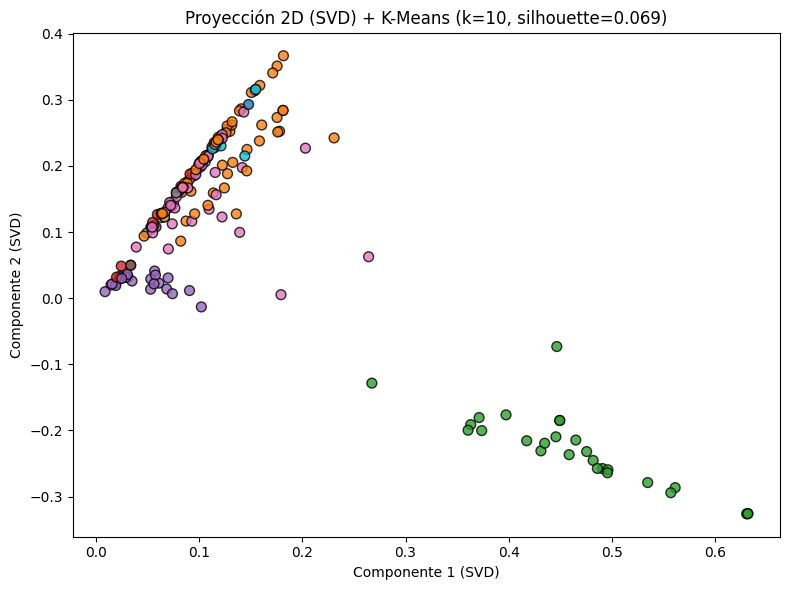

In [33]:
import matplotlib.pyplot as plt

# === Gráfico del clustering K-Means ===
plt.figure(figsize=(8, 6))

# Dibujamos cada punto con su color según el cluster asignado
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    s=50,                    # tamaño de los puntos
    c=labels_kmeans,         # color por cluster
    cmap='tab10',            # paleta de colores (10 colores)
    alpha=0.8,               # transparencia
    edgecolor='k'            # borde negro
)

plt.title(f"Proyección 2D (SVD) + K-Means (k={mejor['k']}, silhouette={mejor['sil']:.3f})", fontsize=12)
plt.xlabel("Componente 1 (SVD)")
plt.ylabel("Componente 2 (SVD)")
plt.tight_layout()

# Guardar y mostrar
plt.savefig("clusters_kmeans.png", dpi=150)
plt.show()


In [34]:
# Opcional: mostrar los títulos de los 5 primeros documentos de cada cluster
for k in sorted(set(labels_kmeans)):
    idx = np.where(labels_kmeans == k)[0][:5]  # primeros 5 de cada cluster
    print(f"\nCluster {k}:")
    for i in idx:
        print("  -", df.iloc[i][COL_TITULO][:80])  # muestra primeras 80 letras del título



Cluster 0:
  - CONOCIMIENTO MATEMÁTICO Y DIDÁCTICO DEL ESTUDIANTE PARA PROFESOR DE EDUCACIÓN PR
  - El modelo MTSK y el conocimiento especializado del profesor de matemáticas en fo

Cluster 1:
  - Una trayectoria de investigación sobre el conocimiento del profesor de matemátic
  - El Papel del MTSK como Modelo de Conocimiento del Profesor en las Interrelacione
  - Uso del Modelo MTSK para la Caracterización del Conocimiento Especializado del P
  - UN EXPERIMENTO DE ENSEÑANZA EN FORMACIÓN CONTINUA ESTRUCTURADO POR EL MODELO MTS
  - Relaciones direccionales intra-dominio del conocimiento especializado del profes

Cluster 2:
  - Teacher knowledge and teacher identity in mathematics education: An interdepende
  - Knowledge and Beliefs of a Teacher Educator: Analysis of her Teaching Practice w
  - Specialized knowledge in teaching exponential function via problem solving in th
  - Conhecimento especializado do professor de matemática e conhecimento interpretat
  - Mathematics Teachers Spe

Con base en el gráfico se pueden ver puntos unos encima del otro de diferentes color, lo cual representa que el mismo punto (artíulo) puede hacer parte de más de un grupo de los 10; esto es lo que explica que la silueta no están bien definidas para las 10 agrupaciones. En ese sentido, hay 3 opciones que se harán más adelante. Por ahora, seguiremos el ejercicio con estos resultados.

### **PASO 3**
- Alternativas: Modelos de mezclas gaussianas(GMM) y DBSCAN.

In [35]:
# 7) GMM: elegimos por BIC (más bajo, mejor)
best_bic = np.inf
labels_gmm = None
best_gmm = None

for k in k_candidates:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=RANDOM_STATE)
    gmm.fit(X_svd)
    bic = gmm.bic(X_svd)
    lab = gmm.predict(X_svd)
    sil = silhouette_score(X_svd, lab)
    metricas.append({
        "modelo":"gmm","k":k,"bic":bic,"silhouette":sil,
        "davies_bouldin": davies_bouldin_score(X_svd, lab),
        "calinski": calinski_harabasz_score(X_svd, lab)
    })
    if bic < best_bic:
        best_bic, labels_gmm, best_gmm = bic, lab, gmm

# 7) DBSCAN: pequeño barrido de parámetros (densidad)
best_dbscan_sil = -1
labels_dbscan = np.full(len(df), -1)
best_db_params = None

for eps in [0.5, 0.8, 1.0]:
    for min_samples in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        lab = db.fit_predict(X_svd)
        # requiere al menos 2 clusters (además de posible ruido -1)
        if len(set(lab)) > 1 and set(lab) != {-1}:
            sil = silhouette_score(X_svd, lab)
            metricas.append({
                "modelo":"dbscan","k":None,"eps":eps,"min_samples":min_samples,
                "silhouette":sil,"davies_bouldin": davies_bouldin_score(X_svd, lab),
                "calinski": calinski_harabasz_score(X_svd, lab)
            })
            if sil > best_dbscan_sil:
                best_dbscan_sil = sil
                labels_dbscan = lab
                best_db_params = {"eps": eps, "min_samples": min_samples}

print("GMM (mejor BIC) -> n_components:", best_gmm.n_components if best_gmm else None)
print("DBSCAN (mejor sil.):", best_db_params, "silhouette:", round(best_dbscan_sil, 3) if best_db_params else None)


GMM (mejor BIC) -> n_components: 4
DBSCAN (mejor sil.): {'eps': 1.0, 'min_samples': 3} silhouette: 0.06


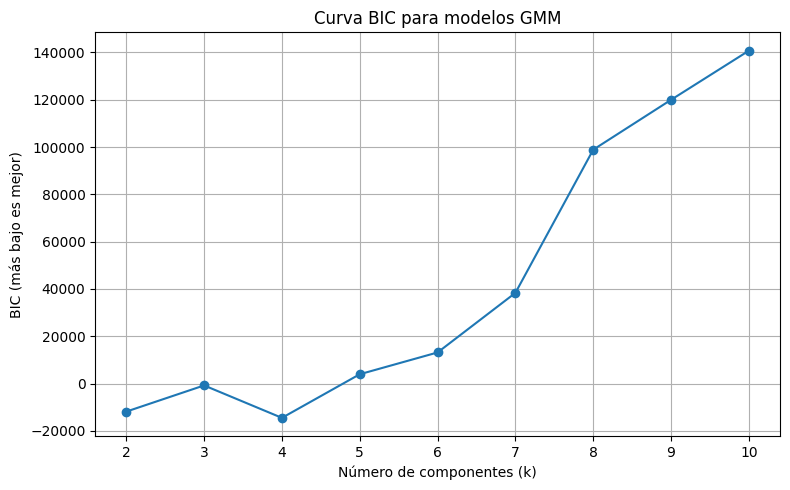

Mejor número de componentes según BIC: 4


In [36]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np

# --- Calcular el BIC para varios k ---
bic_values = []
k_values = range(2, 11)

for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=RANDOM_STATE)
    gmm.fit(X_svd)
    bic_values.append(gmm.bic(X_svd))

# --- Graficar la curva de BIC ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, bic_values, marker='o')
plt.title("Curva BIC para modelos GMM", fontsize=12)
plt.xlabel("Número de componentes (k)")
plt.ylabel("BIC (más bajo es mejor)")
plt.grid(True)
plt.tight_layout()
plt.savefig("gmm_curva_bic.png", dpi=150)
plt.show()

# Mostrar el mejor k
best_k = k_values[np.argmin(bic_values)]
print(f"Mejor número de componentes según BIC: {best_k}")


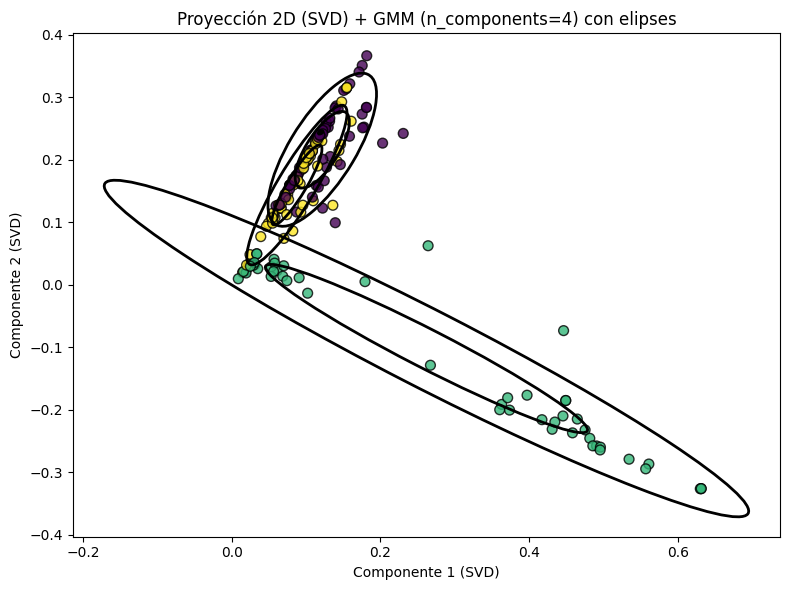

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

# --- 1) Si no existen best_k / best_gmm, los buscamos por BIC ---
try:
    best_k
    best_gmm
except NameError:
    k_values = range(2, 11)
    bic_values = []
    best_bic = np.inf
    best_k = None
    best_gmm = None
    for k in k_values:
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=RANDOM_STATE)
        gmm.fit(X_svd)
        bic = gmm.bic(X_svd)
        bic_values.append(bic)
        if bic < best_bic:
            best_bic = bic
            best_k = k
            best_gmm = gmm

# Etiquetas “duras” para colorear puntos
labels_gmm = best_gmm.predict(X_svd)

# --- 2) Función para dibujar elipses a partir de covarianza 2x2 ---
def draw_ellipse(mean2d, cov2d, ax, n_std=1.0, **kwargs):
    # Autovectores/valores
    vals, vecs = np.linalg.eigh(cov2d)
    # Ordenar mayor -> menor
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    # Ángulo (en grados) del eje mayor
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    # Ancho/alto = 2 * n_std * sqrt(valor propio)
    width, height = 2 * n_std * np.sqrt(vals)
    e = Ellipse(xy=mean2d, width=width, height=height, angle=theta, fill=False, lw=2, **kwargs)
    ax.add_patch(e)

# --- 3) Graficar puntos + elipses (niveles 1 y 2 sigmas) ---
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_gmm, s=50, alpha=0.8, edgecolor='k')

# Medias en 2D (tomamos las 2 primeras dimensiones de las medias del GMM)
means_2d = best_gmm.means_[:, :2]

# Covarianzas en 2D:
# - Si covariance_type == 'full', es una matriz DxD por componente.
#   Tomamos el sub-bloque de 2x2 correspondiente a las dos primeras comp. SVD.
covs_2d = []
if best_gmm.covariance_type == 'full':
    for cov in best_gmm.covariances_:
        covs_2d.append(cov[:2, :2])
elif best_gmm.covariance_type == 'diag':
    for cov in best_gmm.covariances_:
        covs_2d.append(np.diag(cov[:2]))
elif best_gmm.covariance_type == 'tied':
    # misma covarianza para todos: sub-bloque 2x2
    cov2 = best_gmm.covariances_[:2, :2]
    covs_2d = [cov2 for _ in range(best_k)]
elif best_gmm.covariance_type == 'spherical':
    for var in best_gmm.covariances_:
        covs_2d.append(np.eye(2) * var)

# Dibujar elipses por componente (1σ y 2σ)
for m, C in zip(means_2d, covs_2d):
    draw_ellipse(m, C, ax, n_std=1.0)
    draw_ellipse(m, C, ax, n_std=2.0)

ax.set_title(f"Proyección 2D (SVD) + GMM (n_components={best_k}) con elipses")
ax.set_xlabel("Componente 1 (SVD)")
ax.set_ylabel("Componente 2 (SVD)")
plt.tight_layout()
plt.savefig("gmm_clusters_elipses.png", dpi=150)
plt.show()


_Análisis_
En el resultado de aplicar el modelo de mezclas gaussianas nos da como resultado usar 4 componentes, por lo que el hecho de que el mejor modelo sea el de 4 clusters sugiere que el conjunto de textos puede representarse razonablemente bien con un número más pequeño de grupos latentes, en comparación con los 10 de K-Means.

En términos conceptuales, esto puede interpretarse como que los documentos tienden a concentrarse en cuatro grandes áreas semánticas del MTSK, aunque internamente existan subtemas más específicos que K-Means dividió de forma más fina. Dado que GMM asume una distribución probabilística y permite solapamiento entre clusters, sugiere que los límites temáticos entre los documentos son difusos y no rígidos.

Todo lo anterior, es mucho más cercano a lo real, sabiendo, desde e inicio que el MTSK trabaja 5 temáticas (o agrupamientos).

Por otro lado, el modelo DBSCAN identificó una mejor configuración con los parámetros eps = 1.0 y min_samples = 3, obteniendo un silhouette de 0.06, muy similar al obtenido por K-Means (0.069). Esta métrica confirma que no hay una separación fuerte entre los grupos, aunque DBSCAN, al no requerir especificar el número de clusters y detectar ruido, puede haber agrupado documentos “densos” y dejado fuera algunos atípicos. En este contexto, DBSCAN es útil para detectar artículos aislados o poco representativos, mientras que GMM ofrece una visión más global de la estructura temática.

Estos resultados, son interesantes desde el punto de vista ivestigativo, ya que refuerza la idea de que las líneas temáticas del MTSK pueden estar interrelacionadas suscintamente  y que la clasificación automática requiere métodos que capten mejor esa naturaleza continua, como los modelos probabilísticos (GMM).

#### _Extracción de las palabras que usó el modelo de mezclas gaussianas para sugerir los 4 agrupamientos._

In [38]:
# Etiquetas “duras”: el componente más probable para cada documento
df["Cluster_GMM"] = best_gmm.predict(X_svd)

# Contar cuántos documentos hay en cada grupo
print(df["Cluster_GMM"].value_counts())


Cluster_GMM
0    66
3    66
2    54
1     2
Name: count, dtype: int64


In [39]:
# Ver los títulos de los primeros artículos por grupo
for k in sorted(df["Cluster_GMM"].unique()):
    print(f"\n📚 Grupo {k} (Component {k}):")
    subset = df[df["Cluster_GMM"] == k]
    for titulo in subset["Título"].head(5):
        print("  -", titulo)



📚 Grupo 0 (Component 0):
  - Una trayectoria de investigación sobre el conocimiento del profesor de matemáticas: del grupo SIDM a la Red Iberoamericana MTSK
  - El Papel del MTSK como Modelo de Conocimiento del Profesor en las Interrelaciones entre los Espacios de Trabajo Matemático
  - Uso del Modelo MTSK para la Caracterización del Conocimiento Especializado del Profesor de Matemáticas en Secundaria: El caso de la Proporcionalidad
  - Relaciones direccionales intra-dominio del conocimiento especializado del profesor de matemáticas sobre localización en el plano
  - Conocimiento especializado del profesor de matemáticas para enseñar a través de la modelación utilizando las TIC

📚 Grupo 1 (Component 1):
  - UN EXPERIMENTO DE ENSEÑANZA EN FORMACIÓN CONTINUA ESTRUCTURADO POR EL MODELO MTSK
  - UN EXPERIMENTO DE ENSEÑANZA EN FORMACIÓN CONTINUA ESTRUCTURADO POR EL MODELO MTSK

📚 Grupo 2 (Component 2):
  - ConheCimento espeCializado de professoras de eduCação infantil no âmbito da Classifi

In [40]:
# Probabilidades de pertenencia (si no lo has hecho ya)
probabilidades = best_gmm.predict_proba(X_svd)
prob_df = pd.DataFrame(probabilidades, columns=[f"Prob_Cluster_{i}" for i in range(best_k)])

# Añadir info adicional
prob_df["Cluster_GMM"] = best_gmm.predict(X_svd)
prob_df["Título"] = df["Título"].values

# Operar solo sobre columnas de probabilidad
prob_cols = [c for c in prob_df.columns if c.startswith("Prob_Cluster_")]
prob_df[prob_cols] = prob_df[prob_cols].apply(pd.to_numeric, errors="coerce")

# Máxima probabilidad y selección de artículos más ambiguos
prob_df["max_prob"] = prob_df[prob_cols].max(axis=1)
ambig_idx = prob_df["max_prob"].sort_values().head(10).index

# --- Mostrar con 4 decimales ---
pd.options.display.float_format = "{:.4f}".format  # 🔹 Forzar 4 decimales
cols_to_show = ["Título", "Cluster_GMM", "max_prob"] + prob_cols
ambig_table = prob_df.loc[ambig_idx, cols_to_show]

print(ambig_table.to_string(index=False))


                                                                                                                                                                                  Título  Cluster_GMM  max_prob  Prob_Cluster_0  Prob_Cluster_1  Prob_Cluster_2  Prob_Cluster_3
                                                         Una trayectoria de investigación sobre el conocimiento del profesor de matemáticas: del grupo SIDM a la Red Iberoamericana MTSK            0    1.0000          1.0000          0.0000          0.0000          0.0000
                                                              El Papel del MTSK como Modelo de Conocimiento del Profesor en las Interrelaciones entre los Espacios de Trabajo Matemático            0    1.0000          1.0000          0.0000          0.0000          0.0000
                                    Uso del Modelo MTSK para la Caracterización del Conocimiento Especializado del Profesor de Matemáticas en Secundaria: El caso de la Proporcionalidad

In [41]:
df.to_csv("clasificacion_gmm.csv", index=False)
print("Archivo guardado como 'clasificacion_gmm.csv'")


Archivo guardado como 'clasificacion_gmm.csv'


kaksaksakosa

In [42]:
# 8) Interpretación: términos top por cluster (usamos K-Means ganador)
def top_terms_by_cluster(X_tfidf, labels, vectorizer, topn=12) -> pd.DataFrame:
    filas = []
    for k in sorted(set(labels)):
        idx = np.where(labels == k)[0]
        if len(idx) == 0:
            continue
        # "centroide semántico" como media de vectores TF-IDF
        centroid = X_tfidf[idx].mean(axis=0)
        arr = centroid.toarray().ravel() if hasattr(centroid, "toarray") else np.asarray(centroid).ravel()
        top_idx = arr.argsort()[::-1][:topn]
        terms = [vectorizer.get_feature_names_out()[i] for i in top_idx]
        filas.append({"cluster": k, "top_terms": ", ".join(terms)})
    return pd.DataFrame(filas)

top_terms = top_terms_by_cluster(X, labels_kmeans, tfidf, topn=12)
top_terms


,cluster,top_terms
0,0,"fracciones, registra, primaria fracciones, tie..."
1,1,"conocimiento, profesor, matematicas, conocimie..."
2,2,"the, knowledge, and, teacher, mathematics, tea..."
3,3,"registra, registra registra, transito, transit..."
4,4,"conhecimento, formacao, professores, conhecime..."
5,5,"racionais, numeros racionais, estudo, dos nume..."
6,6,"conocimiento, matematicas, profesores, formaci..."
7,7,"conocimiento ensenar, comunidades practica, pr..."
8,8,"crecimiento profesional, crecimiento, profesio..."
9,9,"probabilidad, estadistica, conocimiento, estad..."


In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# --- Descargar stopwords en español si no están ---
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

# --- 1) Unificamos el texto base ---
COL_TITULO = "Título"
COL_RESUMEN = "Resumen (texto literal)"
COL_KEYWORDS = "Palabras clave (texto literal)"

df["texto_completo"] = (
    df[COL_TITULO].fillna("") + " " +
    df[COL_RESUMEN].fillna("") + " " +
    df[COL_KEYWORDS].fillna("")
)

# --- 2) Vectorización TF-IDF ---
vectorizer = TfidfVectorizer(
    max_df=0.85,
    min_df=2,
    stop_words=spanish_stopwords  # Lista real de stopwords en español
)
X_tfidf = vectorizer.fit_transform(df["texto_completo"])
feature_names = vectorizer.get_feature_names_out()

# --- 3) Etiquetas del modelo GMM ---
labels_gmm = best_gmm.predict(X_svd)
df["Cluster_GMM"] = labels_gmm

# --- 4) Promedio de pesos TF-IDF por cluster ---
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
tfidf_df["cluster"] = labels_gmm
cluster_tfidf = tfidf_df.groupby("cluster").mean()

# --- 5) Mostrar los términos más representativos de cada cluster ---
n_top = 15  # cantidad de palabras que quieres ver
for k in range(cluster_tfidf.shape[0]):
    top_terms = cluster_tfidf.loc[k].sort_values(ascending=False).head(n_top)
    print(f"\n🧠 Componente {k} — Principales términos:")
    print(", ".join(top_terms.index))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



🧠 Componente 0 — Principales términos:
conocimiento, profesor, matemáticas, especializado, práctica, modelo, enseñanza, mtsk, relaciones, trabajo, matemático, didáctico, contenido, profesores, formación

🧠 Componente 1 — Principales términos:
experimento, maestros, egresados, enseñanza, conocimiento, formación, profesional, 39, lugar, fundamentación, retrospectivo, infraexplorada, progresión, mejoran, mostraremos

🧠 Componente 2 — Principales términos:
the, of, knowledge, do, and, teacher, conhecimento, in, mathematics, to, teachers, da, em, model, specialized

🧠 Componente 3 — Principales términos:
conocimiento, formación, matemáticas, profesores, mtsk, educación, registra, inicial, especializado, estadística, primaria, matemática, enseñanza, modelo, profesor


In [24]:
# 9) Anomalías (documentos atípicos que no encajan bien)
iso = IsolationForest(random_state=RANDOM_STATE, contamination=0.05)
outlier_flags = iso.fit_predict(X_svd)  # -1 indica outlier
df["anomalia"] = (outlier_flags == -1)
df["cluster_kmeans"] = labels_kmeans
df["cluster_gmm"] = labels_gmm
df["cluster_dbscan"] = labels_dbscan


## **COMPLEMENTO DEL PROYECTO**

Sabemos que

In [47]:
# Ajusta si cambian ruta/sep/encoding
import pandas as pd, numpy as np, re, unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

RUTA_CSV = "DATAMTSK(Hoja1).csv"
SEP = ";"
ENCODING = "latin-1"

COL_TITULO   = "Título"
COL_RESUMEN  = "Resumen (texto literal)"
COL_KEYWORDS = "Palabras clave (texto literal)"

df = pd.read_csv(RUTA_CSV, sep=SEP, encoding=ENCODING)
df.columns = [c.strip() for c in df.columns]
df = df[[COL_TITULO, COL_RESUMEN, COL_KEYWORDS]].copy()

def strip_accents(s):
    import unicodedata
    return ''.join(c for c in unicodedata.normalize('NFD', str(s)) if unicodedata.category(c) != 'Mn')

def clean_text(s):
    import re
    s = strip_accents(str(s).lower())
    s = re.sub(r"[^a-z0-9 ]", " ", s)
    s = re.sub(r"\s+"," ", s).strip()
    return s

df["texto_completo"] = (
    df[COL_TITULO].fillna("") + " " +
    df[COL_KEYWORDS].fillna("") + " " +
    df[COL_RESUMEN].fillna("")
).apply(clean_text)

# TF-IDF + SVD (si ya lo tenías, puedes reutilizar tus variables)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df["texto_completo"])

svd = TruncatedSVD(n_components=min(100, X_tfidf.shape[1]-1), random_state=42)
X_svd = svd.fit_transform(X_tfidf)
X_2d = X_svd[:, :2]


In [48]:
from sklearn.mixture import GaussianMixture

best_k = 5
best_gmm = GaussianMixture(n_components=best_k, covariance_type="full", random_state=42)
labels_gmm = best_gmm.fit_predict(X_svd)

df["Cluster_GMM"] = labels_gmm
print("Documentos por componente:")
print(df["Cluster_GMM"].value_counts().sort_index())


Documentos por componente:
Cluster_GMM
0    123
1      9
2      2
3      2
4     52
Name: count, dtype: int64


In [49]:
import pandas as pd
pd.options.display.float_format = "{:.4f}".format  # 4 decimales en números

feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
tfidf_df["cluster"] = labels_gmm

cluster_tfidf = tfidf_df.groupby("cluster").mean()

# Mostrar y también guardar a CSV
topN = 15
top_words_per_cluster = []

for k in range(best_k):
    top_terms = cluster_tfidf.loc[k].sort_values(ascending=False).head(topN)
    print(f"\n🧠 Componente {k} — Top {topN} términos:")
    print(", ".join(top_terms.index))
    top_words_per_cluster.append({"Cluster": k, "Top_Términos": ", ".join(top_terms.index)})

pd.DataFrame(top_words_per_cluster).to_csv("gmm5_top_terminos_por_componente.csv", index=False)
print("\nGuardado: gmm5_top_terminos_por_componente.csv")



🧠 Componente 0 — Top 15 términos:
de, la, el, del, en, conocimiento, los, profesor, que, matematicas, las, de la, conocimiento especializado, una, un

🧠 Componente 1 — Top 15 términos:
de, la, el, en, conocimiento, los, tareas, conocimiento especializado, formacion, geometria, para, del, que, especializado, matematicas

🧠 Componente 2 — Top 15 términos:
clave resumen, titulo palabras, titulo, resumen, palabras clave, palabras, clave, otros centrar, otros autores, otros aspectos, otros 2014, otros, otro universitario, otros conocimientos, otro lado

🧠 Componente 3 — Top 15 términos:
experimento, de, maestros, egresados, experimento de, del experimento, maestros egresados, en, de ensenanza, de maestros, un experimento, la, el, un, ensenanza

🧠 Componente 4 — Top 15 términos:
the, of, knowledge, and, do, de, in, to, teacher, conhecimento, mathematics, teachers, model, da, specialized

Guardado: gmm5_top_terminos_por_componente.csv


In [50]:
for k in range(best_k):
    print(f"\n📚 Componente {k} — ejemplos de títulos:")
    print("\n".join("- " + t[:100] for t in df[df["Cluster_GMM"]==k][COL_TITULO].head(5)))



📚 Componente 0 — ejemplos de títulos:
- Una trayectoria de investigación sobre el conocimiento del profesor de matemáticas: del grupo SIDM a
- El Papel del MTSK como Modelo de Conocimiento del Profesor en las Interrelaciones entre los Espacios
- Uso del Modelo MTSK para la Caracterización del Conocimiento Especializado del Profesor de Matemátic
- Relaciones direccionales intra-dominio del conocimiento especializado del profesor de matemáticas so
- MTSK en la formación inicial del profesorado de educación infantil para el diseño de actividades

📚 Componente 1 — ejemplos de títulos:
- Articulación del Modelo del Conocimiento Especializado del Docente de Matemática (MTSK) y el Estudio
- Reseña del libro: Tendencias en la educación matemática 2023
- El conocimiento especializado del docente de matemáticas
- Conocimiento movilizado por estudiantes para maestro, al comparar áreas de figuras 2D
- El modelo MTSK y el conocimiento especializado del profesor de matemáticas en formación inicial:

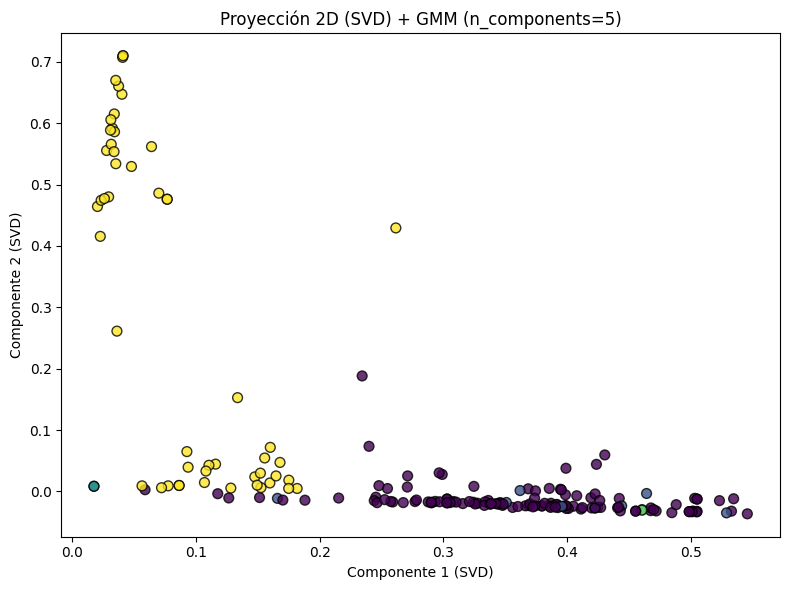

Guardado: gmm5_clusters.png


In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_gmm, s=50, alpha=0.8, edgecolor='k')
plt.title(f"Proyección 2D (SVD) + GMM (n_components={best_k})")
plt.xlabel("Componente 1 (SVD)")
plt.ylabel("Componente 2 (SVD)")
plt.tight_layout()
plt.savefig("gmm5_clusters.png", dpi=150)
plt.show()

print("Guardado: gmm5_clusters.png")


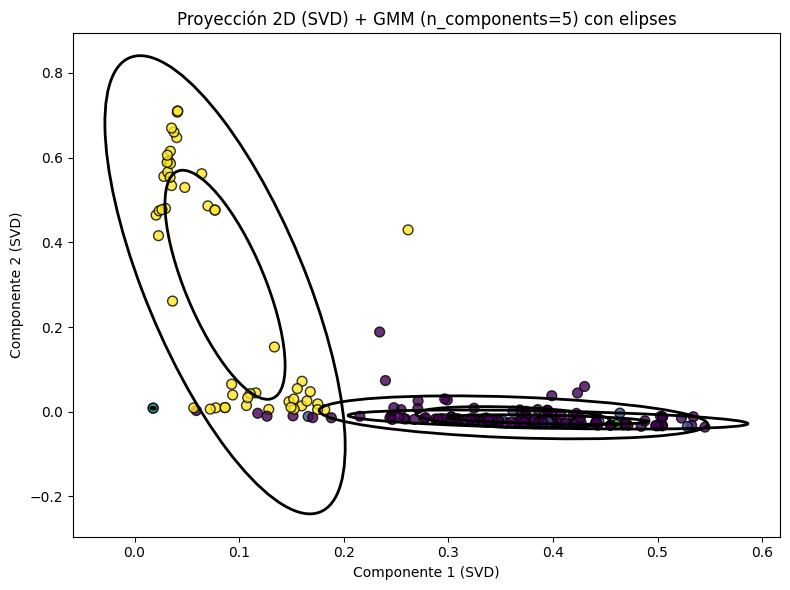

Guardado: gmm5_clusters_elipses.png


In [52]:
import numpy as np
from matplotlib.patches import Ellipse

def draw_ellipse(mean2d, cov2d, ax, n_std=1.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov2d)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2*n_std*np.sqrt(vals)
    e = Ellipse(xy=mean2d, width=width, height=height, angle=theta, fill=False, lw=2, **kwargs)
    ax.add_patch(e)

# Medias y covarianzas proyectadas a 2D (primeras dos dims de SVD)
means_2d = best_gmm.means_[:, :2]
covs_2d = []
if best_gmm.covariance_type == 'full':
    covs_2d = [C[:2, :2] for C in best_gmm.covariances_]
elif best_gmm.covariance_type == 'diag':
    covs_2d = [np.diag(C[:2]) for C in best_gmm.covariances_]
elif best_gmm.covariance_type == 'tied':
    covs_2d = [best_gmm.covariances_[:2, :2] for _ in range(best_k)]
elif best_gmm.covariance_type == 'spherical':
    covs_2d = [np.eye(2)*v for v in best_gmm.covariances_]

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X_2d[:,0], X_2d[:,1], c=labels_gmm, s=50, alpha=0.8, edgecolor='k')

for m, C in zip(means_2d, covs_2d):
    draw_ellipse(m, C, ax, n_std=1.0)
    draw_ellipse(m, C, ax, n_std=2.0)

ax.set_title(f"Proyección 2D (SVD) + GMM (n_components={best_k}) con elipses")
ax.set_xlabel("Componente 1 (SVD)")
ax.set_ylabel("Componente 2 (SVD)")
plt.tight_layout()
plt.savefig("gmm5_clusters_elipses.png", dpi=150)
plt.show()

print("Guardado: gmm5_clusters_elipses.png")


In [53]:
# Palabras semilla (ajústalas a tu criterio)
seed = {
    "T1": {"formacion","docente","practica","tareas","curricular","planes","libros","texto","enseñanza"},
    "T2": {"formador","identidad","profesional","desarrollo","pck","estrategias","aprendizaje","estandares"},
    "T3": {"funciones","geometria","fracciones","numero","algebra","etapas","primaria","secundaria","infantil"},
    "T4": {"kpm","creencias","afectivo","subdominio","modelo","desarrollo","relaciones"},
    "T5": {"tecnologia","recursos","digital","teorias","marcos","extension","disciplinas"}
}

# Score simple: cuántas semillas aparecen en los top términos del cluster
def suggest_label_for_cluster(top_terms_list):
    scores = {k:0 for k in seed}
    for label, words in seed.items():
        scores[label] = sum(1 for w in top_terms_list if w in words)
    # elegir la etiqueta con mayor puntaje; si todo 0, asignar "T?"
    best = max(scores, key=scores.get)
    return best if scores[best] > 0 else "T?"

# Construir sugerencia usando los top términos ya calculados (cluster_tfidf)
mapping_sugerido = {}
for k in range(best_k):
    tops = cluster_tfidf.loc[k].sort_values(ascending=False).head(25).index.tolist()
    mapping_sugerido[k] = suggest_label_for_cluster(tops)

print("\nSugerencia de mapeo componente → temática MTSK:")
for k in range(best_k):
    print(f"  Componente {k} → {mapping_sugerido[k]}")



Sugerencia de mapeo componente → temática MTSK:
  Componente 0 → T4
  Componente 1 → T1
  Componente 2 → T?
  Componente 3 → T1
  Componente 4 → T?


In [54]:
df_export = df[[COL_TITULO, COL_KEYWORDS, COL_RESUMEN]].copy()
df_export["Cluster_GMM"] = labels_gmm
df_export["Tema_Sugerido"] = df_export["Cluster_GMM"].map(mapping_sugerido)

df_export.to_csv("gmm5_clasificacion_con_tema.csv", index=False)
print("Guardado: gmm5_clasificacion_con_tema.csv")


Guardado: gmm5_clasificacion_con_tema.csv


parte 3 del trabajo con las tematicas y coseno


In [59]:
# --- 6) Asignar la temática con mayor similitud (solo sobre columnas numéricas) ---

# Detectar automáticamente las columnas que vienen del cálculo de similitud (float)
num_cols = sim_df.select_dtypes(include=[np.number]).columns.tolist()

# Calcular el índice y valor máximo solo sobre esas columnas
sim_df["Tema_Semantico"] = sim_df[num_cols].idxmax(axis=1)
sim_df["Max_Similitud"] = sim_df[num_cols].max(axis=1)

# --- 7) Integrar con el DataFrame principal ---
df_sem = pd.concat([df, sim_df], axis=1)

# --- 8) Tabla comparativa entre clusters y temáticas ---
tabla_comparativa = (
    df_sem.groupby(["Cluster_GMM", "Tema_Semantico"])
    .size()
    .unstack(fill_value=0)
)
tabla_comparativa["Total_Cluster"] = tabla_comparativa.sum(axis=1)
tabla_comparativa["Tema_Mas_Frecuente"] = (
    tabla_comparativa.drop(columns="Total_Cluster").idxmax(axis=1)
)

# --- 9) Mostrar y guardar resultados ---
pd.options.display.float_format = "{:.4f}".format  # 4 decimales
print("\n📊 Correspondencia entre clusters (GMM=5) y temáticas MTSK:")
display(tabla_comparativa)

df_sem.to_csv("validacion_semantica_MTSK.csv", index=False, float_format="%.4f")
print("\n✅ Archivo guardado: validacion_semantica_MTSK.csv")



📊 Correspondencia entre clusters (GMM=5) y temáticas MTSK:


Tema_Semantico,Aplicaciones de MTSK en la formación de profesores,Extensiones del MTSK,Investigaciones sobre el formador de profesores de matemáticas,MTSK en relación con distintos tópicos y etapas,Total_Cluster,Tema_Mas_Frecuente
Cluster_GMM,,,,,,
0,76,1,45,1,123,Aplicaciones de MTSK en la formación de profes...
1,9,0,0,0,9,Aplicaciones de MTSK en la formación de profes...
2,2,0,0,0,2,Aplicaciones de MTSK en la formación de profes...
3,2,0,0,0,2,Aplicaciones de MTSK en la formación de profes...
4,30,5,3,14,52,Aplicaciones de MTSK en la formación de profes...



✅ Archivo guardado: validacion_semantica_MTSK.csv


<Figure size 1000x600 with 0 Axes>

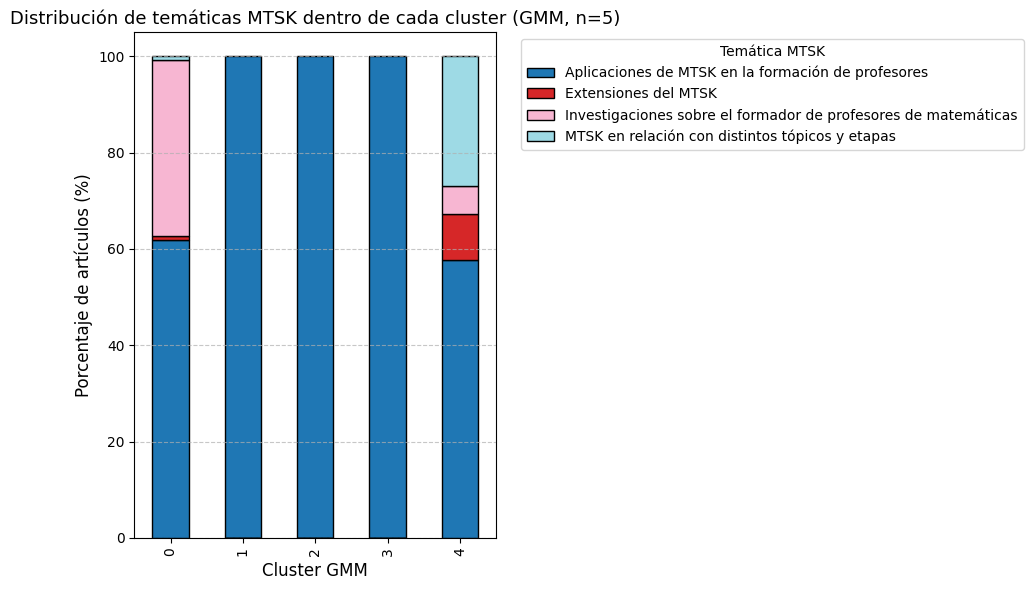

✅ Gráfico guardado como 'grafico_clusters_vs_tematicas_MTSK.png'


In [60]:
import matplotlib.pyplot as plt

# --- Reorganizar tabla para graficar ---
tabla_plot = tabla_comparativa.drop(columns=["Total_Cluster", "Tema_Mas_Frecuente"])
tabla_plot = tabla_plot.div(tabla_plot.sum(axis=1), axis=0) * 100  # porcentajes

# --- Crear gráfico de barras apiladas ---
plt.figure(figsize=(10,6))
tabla_plot.plot(kind="bar", stacked=True, colormap="tab20", figsize=(10,6), edgecolor='black')

plt.title("Distribución de temáticas MTSK dentro de cada cluster (GMM, n=5)", fontsize=13)
plt.xlabel("Cluster GMM", fontsize=12)
plt.ylabel("Porcentaje de artículos (%)", fontsize=12)
plt.legend(title="Temática MTSK", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig("grafico_clusters_vs_tematicas_MTSK.png", dpi=150)
plt.show()

print("✅ Gráfico guardado como 'grafico_clusters_vs_tematicas_MTSK.png'")
